In [1]:
import heapq # Colas de prioridad (heaps)
import time # Para medir el tiempo de ejecucion
import matplotlib.pyplot as plt # Para graficar los resultados

class Node: 
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.state = state # Matriz de 9x9
        self.parent = parent # El nodo padre de donde se origina el nodo actual
        self.action = action # Action tomada desde el padre para llegar al nodo
        self.path_cost = path_cost # Costo de camino desde el nodo raiz hasta el nodo actual - g(n)

    def __lt__(self, other): # Comparar dos objetos de clase node basado en el costo
        return self.path_cost < other.path_cost

In [2]:
# Funcion auxiliar para convertir la matriz a un tuple de tuples
def tuple_conv(matrix):
    return tuple(tuple(row) for row in matrix)

def a_star_search(problem, f):
    amount_explored = 0 # Contador de nodos explorados
    node = Node(state=problem.initial) # Crea el nodo raíz con el estado inicial del problema.
    frontier = [(f(node, problem), node)] # Frontera como una cola de prioridad (f(n)) con el nodo inicial.
    heapq.heapify(frontier) # Convierte la lista frontier en una cola de prioridad (heap)
    
    tuple_init = tuple_conv(problem.initial)
    reached = {tuple_init: node} # Registrar los estados alcanzados y su nodo correspondiente.

    while frontier:
        _, node = heapq.heappop(frontier) # Extrae el nodo con el valor mínimo de f de la frontera.
        amount_explored += 1

        if problem.is_goal(node.state): # Si el estado del nodo es el estado objetivo, devuelve el nodo.
            return node, amount_explored

        for child in expand(problem, node): # Expande el nodo generando sus nodos hijos.
            s = child.state
            s_tuple = tuple_conv(s)
            if s_tuple not in reached or child.path_cost < reached[s_tuple].path_cost: # Si el estado del nodo hijo no ha sido alcanzado antes o si se alcanza con un costo de camino menor, actualiza el dict y añade el nodo hijo a la frontera.
                reached[s_tuple] = child
                heapq.heappush(frontier, (f(child, problem), child)) # Añade el nodo hijo a la frontera

    return None, 0 # Se exploran todos los nodos posibles, y no se encuentra una solución

def expand(problem, node):
    state = node.state # Estado actual
    for action in problem.actions(state): # Todas las matrices posibles que se pueden obtener al llenar una celda vacia
        succesor = problem.result(state, action) # Nuevo estado despues de aplicar la acción
        cost = node.path_cost + 1 # Calcula el costo del nuevo camino usando action_cost = 1
        yield Node(state=succesor, parent=node, action=action, path_cost=cost) # Conserva el valor y pausa la ejecución de la función,
        # Cuando se vuelva a invocar se reiniciará desde la declaración del yield

### Notas frente al planteamiento del problema

- La funcion actions() no proporciona todas las posibilidades de las celdas vacias en un estado n, debido a que es muy costoso en memoria guardar todos los nodos generados en la funcion expand(). Así que, para mejorar la eficiencia, se implementó la heurística MRV (Minimum Remaining Values), la cual permite "seleccionar" la celda vacia con menos posibilidades de movimiento; priorizando así los nodos más "importantes" en la busqueda.

- Oficialmente la funcion heuristica es h1(n) = número de celdas vacias, sin embargo, también se implementó h2(n) = sumatoria de posibilidades de las celdas vacias, la cual muestra mayor eficiencia y rapidez en los tiempos de ejecución.

- Elegimos definir el costo entre nodos como 1 para simplificar el problema. Sin embargo, en el caso de calcular f(n) = g(n) + h2(n), el path_cost (g(n)) tiene un impacto casi insignificante en la búsqueda ya que las heurística h2(n) domina el valor de f(n). Esto se debe a que el path_cost máximo es 81 (llenando todas las celdas de una matriz 9x9 vacía), mientras que h2(n) crece exponencialmente al considerar todas las posibilidades de todas las celdas vacias (lo cual puede ser miles de millones de posibilidades). Por lo tanto, la búsqueda está siendo guiada principalmente por las heurística h2(n) más que por el costo del camino. Nota: lo anterior no pasa al usar h1(n) en f(n) = g(n) + h1(n) debido a que el maximo valor de h1(n) es 81, al igual que el path_cost máximo.

In [3]:
class Problem:
    def __init__(self, initial):
        self.initial = initial # Estado inicial
    
     # Verificación de si el número es válido en la celda (i, j) siguiendo las reglas de Sudoku
    def is_valid(self, state, num, i, j):
        if num in state[i]:
            return False
        
        if any(state[row][j] == num for row in range(9)):
            return False
        
        # Calcular la esquina superior izquierda de la caja 3x3
        box_row = (i // 3) * 3
        box_col = (j // 3) * 3
        
        # Verificar todas las celdas en la caja 3x3
        for row in range(box_row, box_row + 3):
            for col in range(box_col, box_col + 3):
                if state[row][col] == num:
                    return False
                
        return True
    
    # Obtener los valores posibles para una celda, cumpliendo las reglas de Sudoku
    def get_possible_values(self, state, i, j):
        possible_values = []
        for num in range(1, 10):
            if self.is_valid(state, num, i, j):
                possible_values.append(num)
        return possible_values
    
    # Encontrar la celda con el menor numero de opciones posibles
    def min_options(self, state):
        best_cell = None
        min_options = float('inf')
        best_cell_options = []
        
        for i in range(9):
            for j in range(9):
                if state[i][j] == 0:
                    options = self.get_possible_values(state, i, j)
                    if len(options) < min_options:
                        best_cell = (i, j)
                        best_cell_options = options
                        min_options = len(options)
                        
        return best_cell, best_cell_options
    
    # Implementacion Minimum Remaining Values (MRV)
    def actions(self, state):
        actions = []
        best_cell, best_cell_options = self.min_options(state)
        for num in best_cell_options:
            actions.append((best_cell[0], best_cell[1], num))
        return actions
                          
    # Estado resultante de aplicar una acción
    def result(self, state, action): 
        i, j, num = action
        
        # Crear una copia profunda del estado para evitar modificar el original
        new_state = [row[:] for row in state]
        new_state[i][j] = num
        return new_state
                    
    # def action_cost(self): return 1        
    
    # Heurística oficial: numero de celdas vacias
    def h1(self, state): 
        count = 0
        for i in range(9):
            for j in range(9):
                if state[i][j] == 0:
                    count += 1
        return count
    
    # Heuristica alternativa: sumatoria de posibilidades de las celdas vacias
    def h2(self, state): 
        suma = 0
        for i in range(9):
            for j in range(9):
                if state[i][j] == 0:
                    suma += len(self.get_possible_values(state, i, j))
        return suma
    
    # Verificación de si el estado es el estado objetivo
    def is_goal(self, state): 
        for i in range(9):
            for j in range(9):
                if state[i][j] == 0:
                    return False
        return True

In [4]:
# f(n) = g(n) + (h1(n) | h2(n))
def f(node, problem):
    return node.path_cost + problem.h1(node.state)

In [5]:
# Función para graficar cada estado en el camino a la solución
def graph_sudoku(board, last_action=None):

    fig, ax = plt.subplots(figsize=(3,3))

    # Dibujar las líneas de la cuadrícula
    for i in range(10):
        lw = 2 if i % 3 == 0 else 0.5  # más grueso cada 3
        ax.plot([0, 9], [i, i], color="black", linewidth=lw)
        ax.plot([i, i], [0, 9], color="black", linewidth=lw)

    # Escribir los números
    for i in range(9):
        for j in range(9):
            val = board[i][j]
            if val not in (0, None, "", "."):
                color = "black"
                # Resaltar última acción en rojo
                if last_action and (i, j) == (last_action[0], last_action[1]):
                    color = "red"
                ax.text(j+0.5, 8.5-i, str(val), va="center", ha="center",
                        fontsize=10, color=color, fontweight="bold" if color=="red" else "normal")

    # Ajustes de ejes
    ax.set_xlim(0,9)
    ax.set_ylim(0,9)
    ax.axis("off")

    plt.show()


Paso 0 - No action

Step 1 - Placed 3 at position (6, 4)


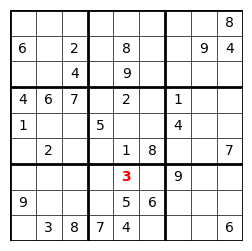


Step 2 - Placed 1 at position (7, 2)


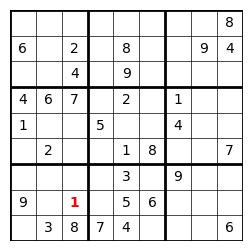


Step 3 - Placed 7 at position (0, 4)


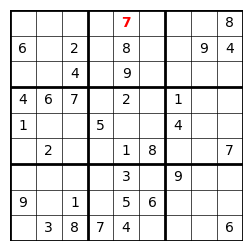


Step 4 - Placed 6 at position (4, 4)


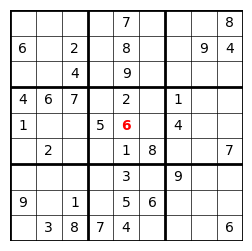


Step 5 - Placed 3 at position (0, 0)


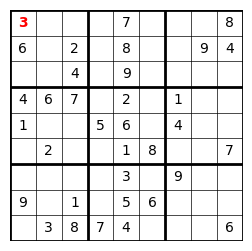


Step 6 - Placed 5 at position (5, 0)


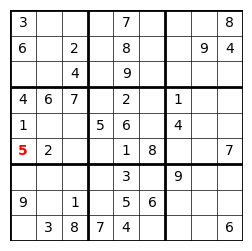


Step 7 - Placed 2 at position (8, 0)


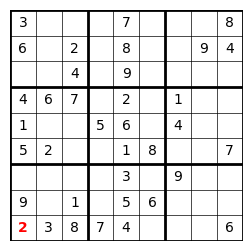


Step 8 - Placed 7 at position (6, 0)


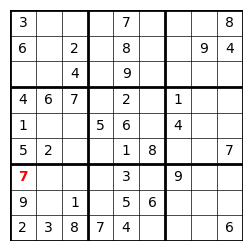


Step 9 - Placed 8 at position (2, 0)


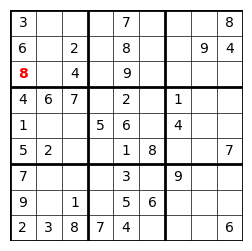


Step 10 - Placed 4 at position (7, 1)


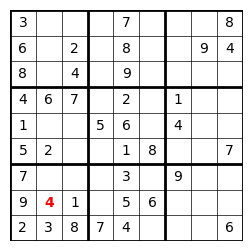


Step 11 - Placed 5 at position (6, 1)


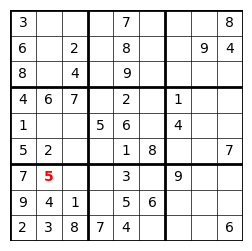


Step 12 - Placed 6 at position (6, 2)


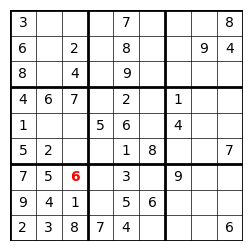


Step 13 - Placed 5 at position (8, 6)


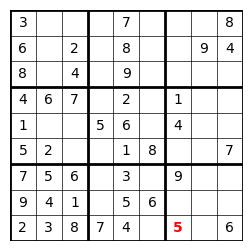


Step 14 - Placed 1 at position (8, 7)


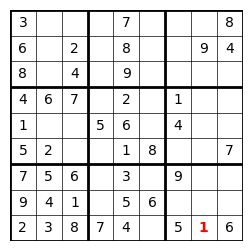


Step 15 - Placed 2 at position (6, 8)


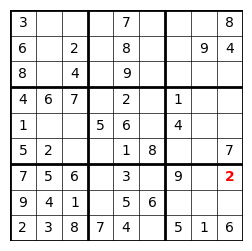


Step 16 - Placed 1 at position (6, 5)


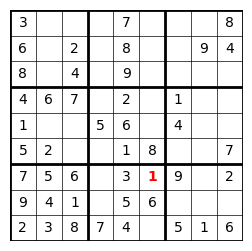


Step 17 - Placed 8 at position (6, 3)


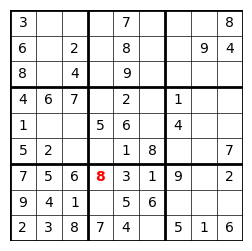


Step 18 - Placed 4 at position (6, 7)


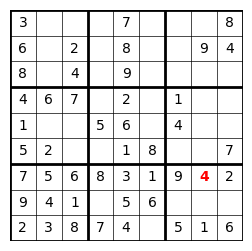


Step 19 - Placed 2 at position (7, 3)


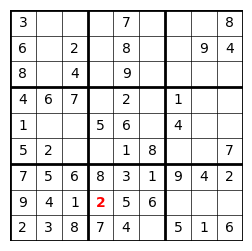


Step 20 - Placed 3 at position (7, 8)


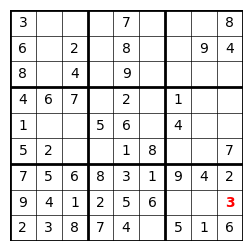


Step 21 - Placed 9 at position (4, 8)


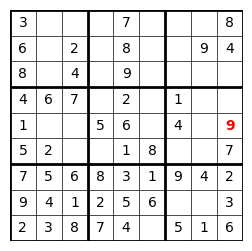


Step 22 - Placed 5 at position (3, 8)


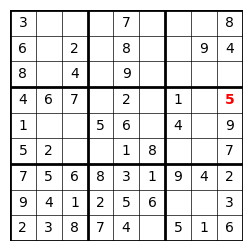


Step 23 - Placed 1 at position (2, 8)


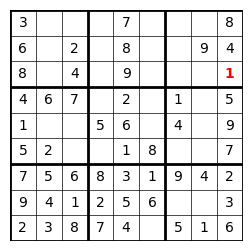


Step 24 - Placed 7 at position (2, 1)


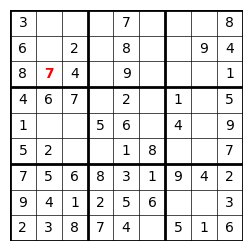


Step 25 - Placed 1 at position (1, 1)


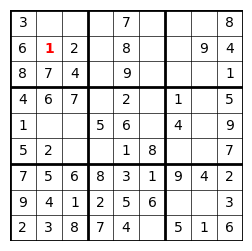


Step 26 - Placed 9 at position (0, 1)


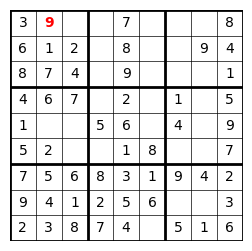


Step 27 - Placed 5 at position (0, 2)


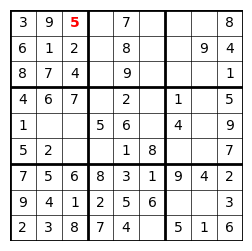


Step 28 - Placed 3 at position (1, 3)


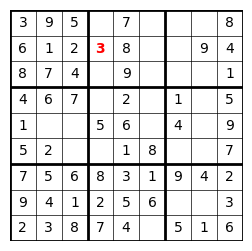


Step 29 - Placed 5 at position (1, 5)


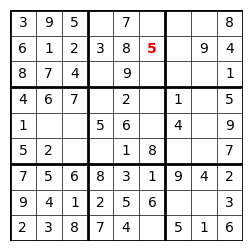


Step 30 - Placed 7 at position (1, 6)


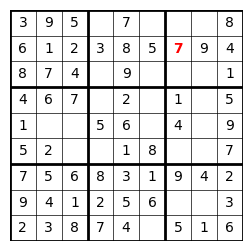


Step 31 - Placed 6 at position (2, 3)


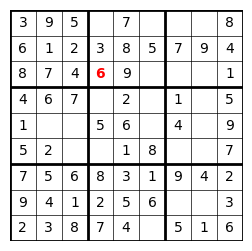


Step 32 - Placed 2 at position (2, 5)


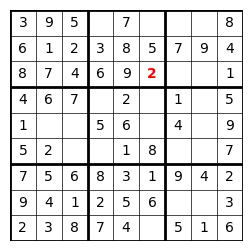


Step 33 - Placed 4 at position (0, 5)


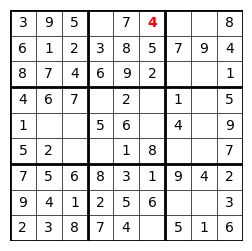


Step 34 - Placed 1 at position (0, 3)


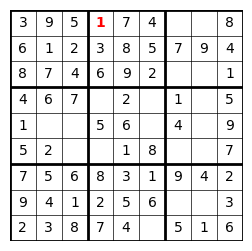


Step 35 - Placed 3 at position (2, 6)


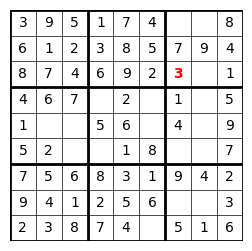


Step 36 - Placed 5 at position (2, 7)


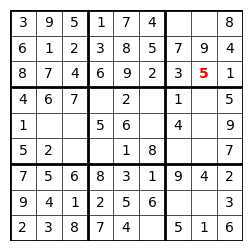


Step 37 - Placed 9 at position (3, 3)


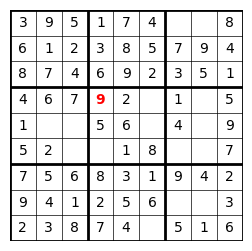


Step 38 - Placed 3 at position (3, 5)


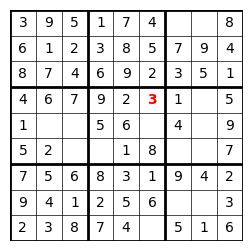


Step 39 - Placed 8 at position (3, 7)


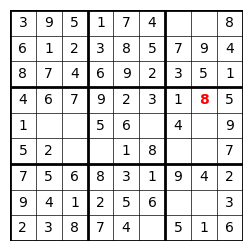


Step 40 - Placed 8 at position (4, 1)


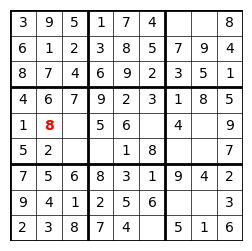


Step 41 - Placed 3 at position (4, 2)


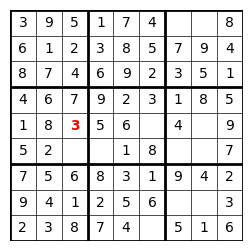


Step 42 - Placed 7 at position (4, 5)


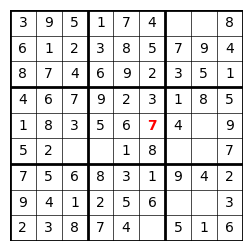


Step 43 - Placed 2 at position (4, 7)


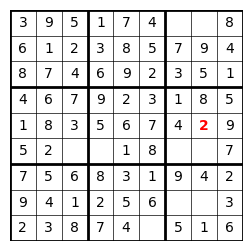


Step 44 - Placed 6 at position (0, 7)


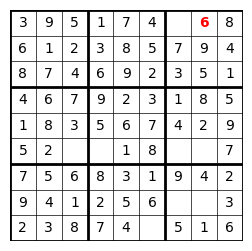


Step 45 - Placed 2 at position (0, 6)


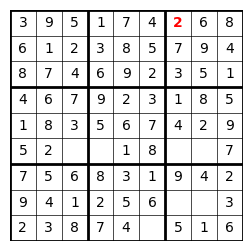


Step 46 - Placed 9 at position (5, 2)


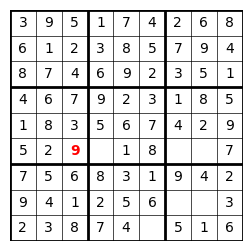


Step 47 - Placed 4 at position (5, 3)


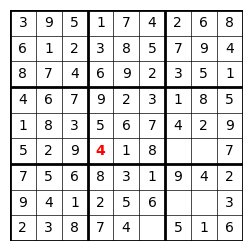


Step 48 - Placed 6 at position (5, 6)


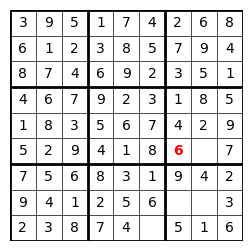


Step 49 - Placed 3 at position (5, 7)


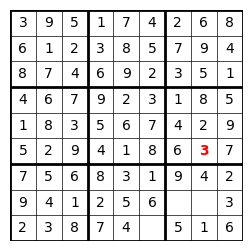


Step 50 - Placed 8 at position (7, 6)


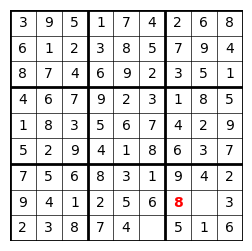


Step 51 - Placed 7 at position (7, 7)


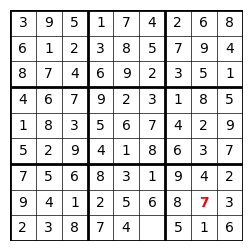


Step 52 - Placed 9 at position (8, 5)


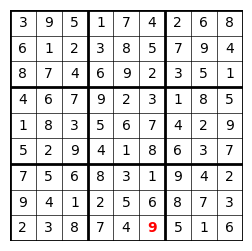


Número total de movimientos: 52
Número total de nodos explorados: 109
Tiempo de ejecución: 0.05 segundos


In [6]:
# Nota: Todo lo que hace h1, h2 lo hace mejor con ~0 segundos de ejecución.

# 29 numeros iniciales -> ~0 segundos con h1
ejercicio_facil = [ 
    [0, 0, 0, 0, 0, 0, 0, 0, 8],
    [6, 0, 2, 0, 8, 0, 0, 9, 4],
    [0, 0, 4, 0, 9, 0, 0, 0, 0],
    [4, 6, 7, 0, 2, 0, 1, 0, 0],
    [1, 0, 0, 5, 0, 0, 4, 0, 0],
    [0, 2, 0, 0, 1, 8, 0, 0, 7],
    [0, 0, 0, 0, 0, 0, 9, 0, 0],
    [9, 0, 0, 0, 5, 6, 0, 0, 0],
    [0, 3, 8, 7, 4, 0, 0, 0, 6]
]

# 22 numeros iniciales -> ~10 segundos con h1
ejercicio_intermedio = [ 
    [9, 0, 0, 0, 0, 3, 0, 0, 0],
    [0, 4, 0, 1, 0, 0, 0, 2, 0],
    [0, 0, 0, 0, 0, 0, 7, 0, 0],
    [0, 5, 0, 0, 8, 0, 0, 0, 1],
    [0, 0, 0, 0, 6, 0, 2, 4, 0],
    [7, 0, 0, 0, 0, 0, 0, 0, 3],
    [0, 0, 9, 0, 4, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 8, 0],
    [8, 0, 0, 7, 0, 5, 0, 9, 0]
]

# 21 numeros iniciales -> ~1 minuto con h1
ejercicio_dificil = [ 
    [9, 0, 0, 0, 0, 3, 0, 0, 0],
    [0, 4, 0, 1, 0, 0, 0, 2, 0],
    [0, 0, 0, 0, 0, 0, 7, 0, 0],
    [0, 5, 0, 0, 8, 0, 0, 0, 1],
    [0, 0, 0, 0, 6, 0, 2, 0, 0],
    [7, 0, 0, 0, 0, 0, 0, 0, 3],
    [0, 0, 9, 0, 4, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 8, 0],
    [8, 0, 0, 7, 0, 5, 0, 9, 0]
]

# 20 numeros iniciales -> ~5 minutos con h1
ejercicio_muy_dificil = [ 
    [9, 0, 0, 0, 0, 3, 0, 0, 0],
    [0, 4, 0, 1, 0, 0, 0, 2, 0],
    [0, 0, 0, 0, 0, 0, 7, 0, 0],
    [0, 5, 0, 0, 8, 0, 0, 0, 1],
    [0, 0, 0, 0, 6, 0, 2, 0, 0],
    [7, 0, 0, 0, 0, 0, 0, 0, 3],
    [0, 0, 9, 0, 4, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 8, 0],
    [8, 0, 0, 7, 0, 5, 0, 9, 0]
]

# 3 numeros iniciales -> ~0 segundos con h2 (con h1 se llena la memoria)
ejercicio_casi_imposible = [ 
    [0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 2, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 7, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]
]

# Seleccionar el Sudoku a resolver
problem = Problem(ejercicio_facil)

# Busqueda A* y calcular tiempo de ejecucion
start_time = time.time()
solution, amount_explored = a_star_search(problem, f)
end_time = time.time()
execution_time = end_time - start_time

# Imprimir la solución
if solution:
    path = []
    while solution:
        path.append(solution)
        solution = solution.parent
    path.reverse()
    
    for step in range(len(path)):
        if path[step].action:
            x, y, value = path[step].action
            print(f"\nStep {step} - Placed {value} at position ({x}, {y})")
            graph_sudoku(path[step].state, last_action=(x,y,value))
        else:
            print(f"\nPaso {step} - No action")
            
    print("\nNúmero total de movimientos:", len(path) - 1)
    print("Número total de nodos explorados:", amount_explored)
    print("Tiempo de ejecución:", round(execution_time, 2), "segundos")
else:
    print("No solution found")